In [237]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
import numpy.ma as ma
import cartopy.crs as ccrs
from tqdm import tqdm_notebook as tqdm

import mplotutils as mpu
import cf_units

In [328]:
def linregress_grid(df,df_time,start,end):
    x,y=np.meshgrid(np.arange(72),np.arange(144))
    slope=np.zeros([72,144])
    i_start=np.where(df_time==start)[0][0]
    i_end=np.where(df_time==end)[0][0]
    
    for i_x, i_y in zip(x.flatten(),y.flatten()):
        slope[i_x,i_y]=10*stats.linregress(np.arange(end-start),df[i_start:i_end,i_x,i_y])[0]
    return slope

def mean_trend_from_dict(df,df_time,start,end, roll=False):
    
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(np.mean(all_trends,axis=0),72,1)
    else:
        return np.mean(all_trends,axis=0)
    
def trend_dist_from_dict(df,df_time,start,end, roll=False):
    
    all_trends=np.stack([linregress_grid(df[key],df_time,start,end) for key in tqdm(df.keys())])
    
    if roll:
        return np.roll(np.quantile(all_trends,[0.05,0.95],axis=0),72,1)
    else:
        return np.quantile(all_trends,[0.05,0.95],axis=0)
        
            
            

In [333]:
##Quick dirty way of getting nan mask from Knutson's dataset

df_1951_2010=xr.open_dataset('9cat.195101-201012.nc').roll(LON=72, roll_coords=True)
arr_1951_2010=np.full([72, 144],np.nan)

arr_1951_2010[(df_1951_2010.CP4.values==4).reshape(72, 144)]=3
arr_1951_2010[(df_1951_2010.CP3.values==3).reshape(72, 144)]=3
arr_1951_2010[(df_1951_2010.CP2.values==2).reshape(72, 144)]=2
arr_1951_2010[(df_1951_2010.CP1.values==1).reshape(72, 144)]=1
arr_1951_2010[(df_1951_2010.CP0.values==0).reshape(72, 144)]=0
arr_1951_2010[(df_1951_2010.CM4.values==-4).reshape(72, 144)]=-3
arr_1951_2010[(df_1951_2010.CM3.values==-3).reshape(72, 144)]=-3
arr_1951_2010[(df_1951_2010.CM2.values==-2).reshape(72, 144)]=-2
arr_1951_2010[(df_1951_2010.CM1.values==-1).reshape(72, 144)]=-1

nan_mask_knut=np.isnan(arr_1951_2010)

In [ ]:
df_gpcc=xr.open_mfdataset('precip.mon.total.2.5x2.5.v2018.nc').groupby('time.year').mean('time')
df_gpcc= df_gpcc.roll(lon=72).sortby('lat').assign_coords(lon= (((df_gpcc.lon + 180) % 360) - 180))
##lat is flipped for some reason

trend_2010_gpcc={}
trend_2016_gpcc={}


for ref in [1951]:
    
    trend_2010_gpcc[ref]=linregress_grid(df_gpcc.sel(year=slice(1870,2021)).precip.values,
                         df_gpcc.sel(year=slice(1870,2021)).year.values,ref,2010)
    trend_2016_gpcc[ref]=linregress_grid(df_gpcc.sel(year=slice(1870,2021)).precip.values,
                         df_gpcc.sel(year=slice(1870,2021)).year.values,ref,2016)
    
    trend_2010_gpcc[ref][nan_mask_knut]=np.nan
    trend_2016_gpcc[ref][nan_mask_knut]=np.nan


In [ ]:
##Get model results
import glob

##create datasetsfor allforcing af, historical natural hn and preindustrial control piCONTROL
y_af={}
y_hn={}
y_pi={}

models=['MIROC6','IPSL-CM6A-LR','CanESM5','HadGEM3-GC31-LL','CNRM-CM6-1','GFDL-ESM4','ACCESS-ESM1-5','BCC-CSM2-MR',
       'NorESM2-LM','CESM2']

for model in models:

    dir_var_af='/net/atmos/data/cmip6-ng/pr/ann/g025/'
    run_name_af_list=sorted(glob.glob(dir_var_af+'pr_ann_'+model+'_ssp585_'+'r*i1p1f*'+'_g025.nc'))
    y_af[model]={}
    for i,run_name_af in enumerate(run_name_af_list):
        run_name_hist = run_name_af.replace('ssp585','historical') 
        data=xr.open_mfdataset([run_name_hist,run_name_af],concat_dim='time').sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72).assign_coords(lon= np.sort(((data.lon + 180) % 360) - 180))
        y_af[model][i]=2.628e+6*data.pr.values   
    
    dir_var_hn='/net/atmos/data/cmip6-ng/pr/ann/g025/'
    run_name_hn_list=sorted(glob.glob(dir_var_hn+'pr_ann_'+model+'_hist-nat_'+'r*i1p1f*'+'_g025.nc'))
    y_hn[model]={}
    for i,run_name_hn in enumerate(run_name_hn_list): 
        data=xr.open_mfdataset(run_name_hn).sel(time=slice('1870-01-01', '2101-01-01')).roll(lon=72).assign_coords(lon= np.sort(((data.lon + 180) % 360) - 180)) ## select 1870 onwards (usually goes till 2016)
        y_hn[model][i]=2.628e+6*data.pr.values
        
    dir_var_pi='/net/atmos/data/cmip6-ng/pr/ann/g025/'
    run_name_pi_list=sorted(glob.glob(dir_var_hn+'pr_ann_'+model+'_piControl_'+'r*i1p1f*'+'_g025.nc'))
    y_pi[model]={}
    for i,run_name_pi in enumerate(run_name_pi_list): 
        data=xr.open_mfdataset(run_name_pi).roll(lon=72).assign_coords(lon= np.sort(((data.lon + 180) % 360) - 180))
        y_pi[model][i]=2.628e+6*data.pr.values
        
    lon=data.lon.values
    lat=data.lat.values
        


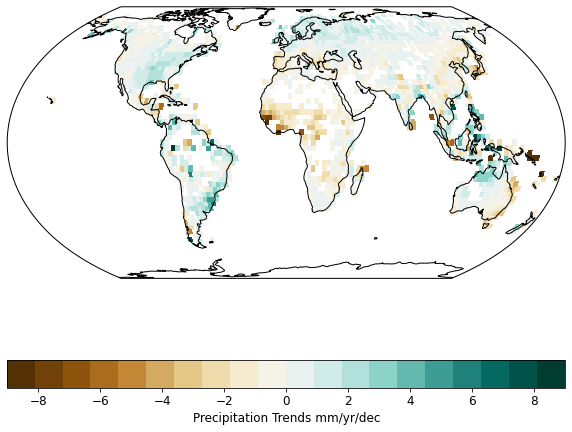

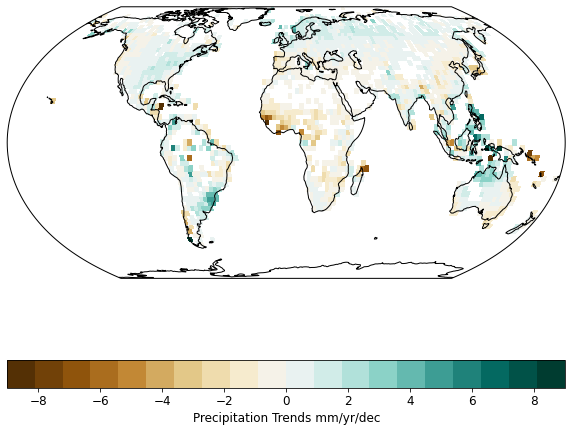

In [337]:
##plot trends from GPCC model

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines()
mesh_1=ax.pcolormesh(lon, lat, trend_2010_gpcc[ref], transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG',20),vmin=-9,vmax=9,rasterized=True)
cmap_mesh=mesh_1.get_cmap()
cmap_mesh.set_bad('gray')
mesh_1.set_cmap(cmap_mesh)

plt.colorbar(mesh_1,orientation='horizontal',label='Precipitation Trends mm/yr/dec')


fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines()
mesh_1=ax.pcolormesh(lon, lat, trend_2016_gpcc[ref], transform=ccrs.PlateCarree(), cmap=plt.cm.get_cmap('BrBG',20),vmin=-9,vmax=9,rasterized=True)
cmap_mesh=mesh_1.get_cmap()
cmap_mesh.set_bad('gray')
mesh_1.set_cmap(cmap_mesh)

plt.colorbar(mesh_1,orientation='horizontal',label='Precipitation Trends mm/yr/dec')


In [249]:
from scipy.stats import linregress

## Drift correct the models preindustrial control runs
y_pi_dc={}

for model in models:
    
    if len(y_pi[model])>1:
        y_pi_temp=np.vstack(([y_pi[model][key] for key in y_pi[model].keys()]))
        y_pi_dc[model]=np.zeros_like(y_pi_temp)
    else:
        y_pi_dc[model]=np.zeros_like(y_pi[model][0])
        
    x,y=np.meshgrid(np.arange(y_pi[model][0].shape[1]),np.arange(y_pi[model][0].shape[2]))
    
    i_key=0
    for key in y_pi[model].keys():
        for i_x, i_y in zip(x.flatten(),y.flatten()):
            #print(i_x,i_y)
            slope, intercept,_,_,_=linregress(np.arange(y_pi[model][key].shape[0]),
                                              y_pi[model][key][:,i_x,i_y])
            drift=slope*np.arange(y_pi[model][key].shape[0])+intercept
            y_pi_dc[model][i_key:i_key+y_pi[model][key].shape[0],i_x,i_y]=y_pi[model][key][:,i_x,i_y]-drift
            
        i_key+=y_pi[model][key].shape[0]
    
        

In [ ]:
trend_2010_hn={}
trend_2010_af={}

resampled_trend_hn_2010={}
resampled_trend_af_2010={}

trend_2016_hn={}
trend_2016_af={}

resampled_trend_hn_2016={}
resampled_trend_af_2016={}

time={}

n_samples=50

for model in models:
    
    if model=='NorESM2-LM':
        continue
    
    print('Creating trend distribution for', model)
    time[model]=np.arange(1870,2101)
    
    trend_2010_hn[model]={}
    trend_2010_af[model]={}
    
    resampled_trend_hn_2010[model]={}
    resampled_trend_af_2010[model]={}

    trend_2016_hn[model]={}
    trend_2016_af[model]={}
    
    resampled_trend_hn_2016[model]={}
    resampled_trend_af_2016[model]={}
    

    for ref in [1951]:
        
        trend_2010_hn[model][ref]=mean_trend_from_dict(y_hn[model],time[model],ref,2010)
        if model=='CESM2':
            trend_2016_hn[model][ref]=mean_trend_from_dict(y_hn[model],time[model],ref,2014)
        else:
            trend_2016_hn[model][ref]=mean_trend_from_dict(y_hn[model],time[model],ref,2016)

        trend_2010_af[model][ref]=mean_trend_from_dict(y_hn[model],time[model],ref,2010)
        trend_2016_af[model][ref]=mean_trend_from_dict(y_af[model],time[model],ref,2016)
    

        resampled_trend_hn_2010[model][ref]=np.zeros([n_samples,trend_2010_hn[model][ref].shape[0],
                                              trend_2010_hn[model][ref].shape[1]])

        resampled_trend_af_2010[model][ref]=np.zeros([n_samples,trend_2010_af[model][ref].shape[0],
                                              trend_2010_af[model][ref].shape[1]])
        
        resampled_trend_hn_2016[model][ref]=np.zeros([n_samples,trend_2016_hn[model][ref].shape[0],
                                              trend_2016_hn[model][ref].shape[1]])

        resampled_trend_af_2016[model][ref]=np.zeros([n_samples,trend_2016_af[model][ref].shape[0],
                                              trend_2016_af[model][ref].shape[1]])

   
        for sample in tqdm(range(n_samples)):

            start_pi=np.random.randint(0,y_pi_dc[model].shape[0]-150)
            end_pi=start_pi+150

            
            resampled_trend_hn_2010[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)+trend_2010_hn[model][ref])
            resampled_trend_af_2010[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)+trend_2010_af[model][ref])
            
            resampled_trend_hn_2016[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)+trend_2016_hn[model][ref])
            resampled_trend_af_2016[model][ref][sample,:,:]=(linregress_grid(y_pi_dc[model],np.arange(y_pi_dc[model].shape[0]),
                                                                        start_pi,end_pi)+trend_2016_af[model][ref])
            

In [343]:
for ref in [1951]:
    
    resampled_trend_hn_2010[ref]=np.stack(([np.mean(resampled_trend_hn_2010[mod][ref],axis=0) for mod in models if mod!='NorESM2-LM']))
    
    resampled_trend_af_2010[ref]=np.stack(([np.mean(resampled_trend_af_2010[mod][ref],axis=0) for mod in models if mod!='NorESM2-LM']))
    
    resampled_trend_hn_2016[ref]=np.stack(([np.mean(resampled_trend_hn_2016[mod][ref],axis=0) for mod in models if mod!='NorESM2-LM']))
    
    resampled_trend_af_2016[ref]=np.stack(([np.mean(resampled_trend_af_2016[mod][ref],axis=0) for mod in models if mod!='NorESM2-LM']))

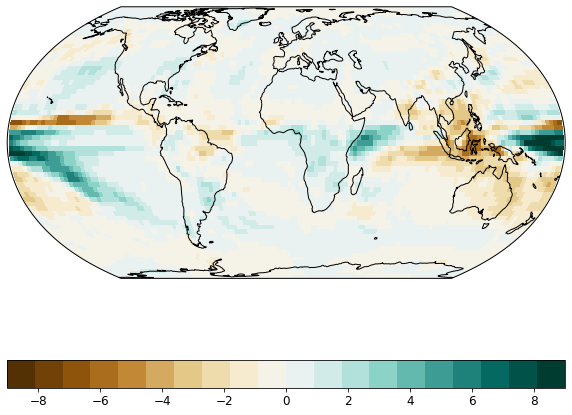

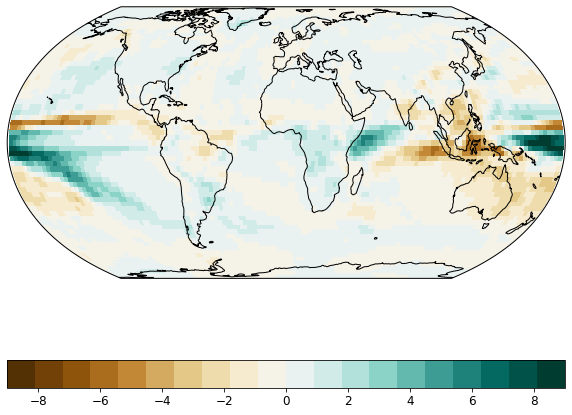

In [344]:
##plot selected natural-forcing trend distributions 

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines()


mesh_1=ax.pcolormesh(lon, lat, resampled_trend_hn_2010[ref][8], transform=ccrs.PlateCarree(),  cmap=plt.cm.get_cmap('BrBG',20),vmin=-9,vmax=9,rasterized=True)
plt.colorbar(mesh_1,orientation='horizontal',ticks=[-8,-4,-2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4, 8])

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines()

mesh_1=ax.pcolormesh(lon, lat, resampled_trend_hn_2016[ref][8], transform=ccrs.PlateCarree(),  cmap=plt.cm.get_cmap('BrBG',20),vmin=-9,vmax=9,rasterized=True)
plt.colorbar(mesh_1,orientation='horizontal',ticks=[-8,-4,-2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4, 8])

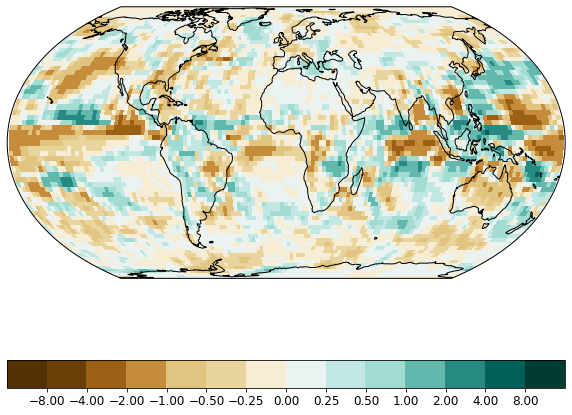

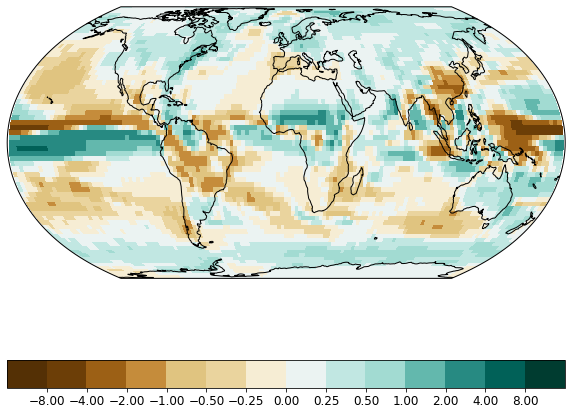

In [381]:
##plot selected all-forcing trend distributions 

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines()

cmap = plt.cm.get_cmap('BrBG',24)

bounds = [ -9,-8,-4,-2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4, 8, 9]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

mesh_1=ax.pcolormesh(lon, lat, resampled_trend_af_2010[ref][0], transform=ccrs.PlateCarree(),  cmap=cmap, norm=norm,vmin=-9,vmax=9,rasterized=True)
plt.colorbar(mesh_1,orientation='horizontal',ticks=[-8,-4,-2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4, 8])

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines()

mesh_1=ax.pcolormesh(lon, lat, resampled_trend_af_2016[ref][0], transform=ccrs.PlateCarree(),  cmap=cmap, norm=norm, vmin=-9,vmax=9,rasterized=True)
plt.colorbar(mesh_1,orientation='horizontal',ticks=[-8,-4,-2, -1, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4, 8])

In [385]:
from scipy.stats import percentileofscore
## need to find a more elegant method, this is quick and dirty

def attr_categorize(af_quantiles,hn_quantiles,obs_trend):
    sign=np.sign(obs_trend)
    
    percentile_af=percentileofscore(af_quantiles,obs_trend)
    percentile_hn=percentileofscore(hn_quantiles,obs_trend)
    
    if sign==1:
        if percentile_af>5 and percentile_af<95:
            if percentile_hn<=95:
                return 0
            else:
                return 2
        elif (percentile_hn<95 and percentile_hn>5):
            return 0
        elif (percentile_af<=5 and percentile_hn>=95):
            return 1
        elif percentile_hn<=5:
            return 0
        elif percentile_af>=95:
            if np.sign(np.average(af_quantiles))!=sign:
                if percentile_hn>5:
                    print(percentile_hn,percentile_af)
                    return 0
                else:
                    return 0
            else:
                return 3
        
    elif sign==-1:
        
        if (percentile_af<95 and percentile_af>5):
            if percentile_hn>=5:
                return 0
            else:
                return -2
        elif (percentile_hn>5 and percentile_hn<95):
            return 0
        elif (percentile_hn<=5 and percentile_af>=95):
            return -1
        elif percentile_hn>=95:
            return 0
        elif percentile_af<=5:
            if np.sign(np.average(af_quantiles))!=sign:
                if percentile_hn>5:
                    print(percentile_hn,percentile_af)
                    return 0
                else:
                    return 0
            else:
                return -3
        

In [ ]:
## Assign attribution categories
ref=1951

attr_2010=np.full([72,144],np.nan)
attr_2016=np.full([72,144],np.nan)

x,y=np.meshgrid(np.arange(72),np.arange(144))

for i_x, i_y in zip(x.flatten(),y.flatten()):
                                          
    attr_2010[i_x,i_y]=attr_categorize(resampled_trend_af_2010[ref][:,i_x,i_y],
                                                         resampled_trend_hn_2010[ref][:,i_x,i_y],
                                            trend_2010_gpcc[ref].reshape(1,72,144)[:,i_x,i_y])

    attr_2016[i_x,i_y]=attr_categorize(resampled_trend_af_2016[ref][:,i_x,i_y],
                                                         resampled_trend_hn_2016[ref][:,i_x,i_y],
                                            trend_2016_gpcc[ref].reshape(1,72,144)[:,i_x,i_y])


(0.0, 1.0, 0.0, 1.0)

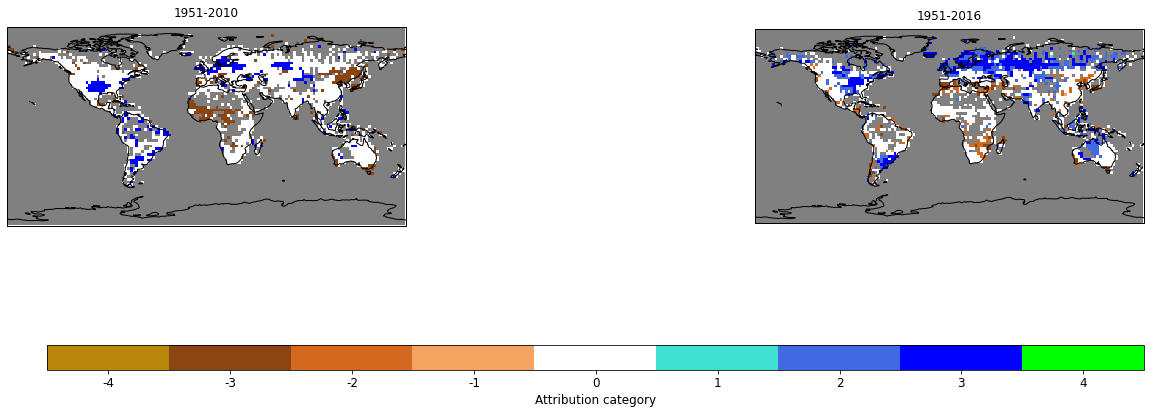

In [387]:
import matplotlib as mpl
n_col = 2
n_row = 3

fs_title=16

fig=plt.figure(figsize=(n_col*13, n_row * 11))
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*3, n_col*9+3, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

cmap = mpl.colors.ListedColormap(['darkgoldenrod','saddlebrown','chocolate','sandybrown','white',
                                  'turquoise','royalblue','blue','lime'])

bounds = [ -4.5,-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5,4.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

i=0
for ref in [1951]:
    
    
    res_2010_plt=attr_2010
    
    res_2016_plt=attr_2016
    
    plt.title('Trend assessment using observation median values')
    i_y=0

    ax = plt.subplot(grid[i+1:i+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree())
    
    ax.coastlines()
    mesh_1=ax.pcolormesh(lon, lat, res_2010_plt, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,vmin=-5.5,rasterized=True)
    
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
    ax.set_title("%i-2010"%(ref),y=1.02,fontsize=12)
    
    i_y+=1
    i+=1

    ax = plt.subplot(grid[i-(i%2)+1:i-(i%2)+2,i_y*15:i_y*15+15], projection=ccrs.PlateCarree())

    i_y+=1
    i+=1
  
    
    ax.coastlines()
    mesh_1=ax.pcolormesh(lon, lat, res_2016_plt, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,vmin=-5.5,rasterized=True)
    
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
    
    ax.set_title("%i-2016"%(ref),y=1.02,fontsize=12)
    
axcbar = plt.subplot(grid[i-(i%2):i-(i%2)+1,5:25])
cbar=plt.colorbar(mesh_1,orientation='horizontal',ticks=[-4,-3,-2,-1,0,1,2,3,4],fraction=0.4,aspect=45)
cbar.set_label('Attribution category')
cbar.ax.set_xlim(-4.5,4.5)
cbar.ax.set_xticklabels(np.arange(-4,5))
plt.axis('off')   


In [390]:
df_attr=xr.Dataset(
    {
        "Attribution_Category_2016": (["latitude", "longitude"],attr_2016),
        "Attribution_Category_2010": (["latitude", "longitude"],attr_2010)
    },
    coords={
        "longitude": (["longitude"], lon),
        "latitude": (["latitude"], lat),
    },
)

df_attr.to_netcdf('precip_attribution_categories_g05_centred_ultimate.nc')

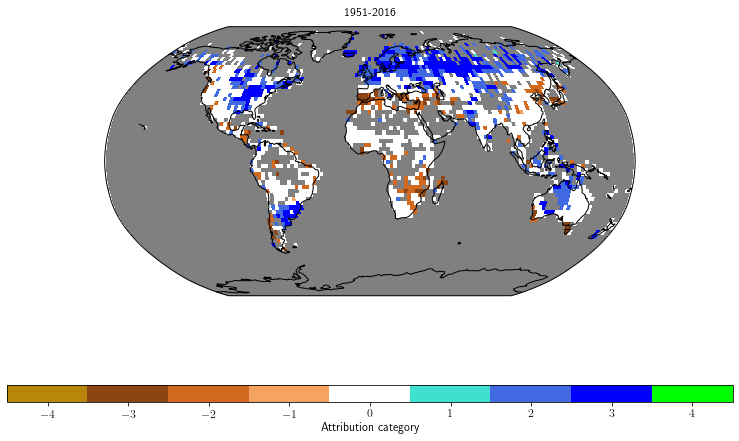

In [391]:
import matplotlib as mpl
n_col = 1
n_row = 1

fs_title=16

fig=plt.figure(figsize=(n_col*13, n_row * 11))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
})


grid = plt.GridSpec(1, 1, wspace=1, hspace=0) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

cmap = mpl.colors.ListedColormap(['darkgoldenrod','saddlebrown','chocolate','sandybrown','white',
                                  'turquoise','royalblue','blue','lime'])

bounds = [ -4.5,-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5,4.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

i=0
for ref in [1951]:
   
    
    ax = plt.subplot(grid[0,0], projection=ccrs.Robinson())
   
    res_2016_plt=df_attr.Attribution_Category_2016.values
    
    ax.coastlines()
    mesh_1=ax.pcolormesh(lon, lat, res_2016_plt, transform=ccrs.PlateCarree(),cmap=cmap,norm=norm,vmin=-4.5,rasterized=True)
    ax.set_title("%i-2016"%(ref),y=1.02,fontsize=12)
    
    plt.colorbar(mesh_1,orientation='horizontal',ticks=[-4,-3,-2,-1,0,1,2,3,4],fraction=0.4,aspect=45,extend='neither',label='Attribution category')
    
    cmap_mesh=mesh_1.get_cmap()
    cmap_mesh.set_bad('gray')
    mesh_1.set_cmap(cmap_mesh)
   


# Plotting

In [388]:
## save functions to access in temperature notebook

np.save('trend_1951_2016_gpcc.npy',trend_2016_gpcc[ref])
np.save('trend_1951_2016_af.npy',np.mean(resampled_trend_af_2016[ref],axis=0))